# CLEAN BUILD FROM SCRATCH MIT-B2 on patches 768x768

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

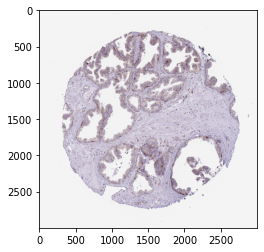

In [3]:
img1 = cv.imread('./../data/train_images/10044.tiff')[:, :, ::-1]
plt.imshow(img1)
plt.show()

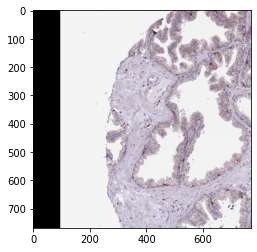

In [4]:
img2 = cv.imread('./../data/train_images_patches_768_overlap/10044_00010.png')[:, :, ::-1]
plt.imshow(img2)
plt.show()

In [5]:
# for fname in tqdm(glob('./../data/train_images_patches_768_overlap/*.png')):
#     img = cv.imread(fname)
#     cv.imwrite(fname, img[:, :, ::-1])

# data

In [6]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [7]:
from model import Net
from mit import *

## data 768

In [8]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_images_patches_768_overlap/'
TRAIN_MASKS_DIR = './../data/train_masks_patches_768_overlap/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 768 # размер патча


In [9]:
train_df = pd.read_csv(TRAIN_CSV)

In [10]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [11]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [12]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [13]:
def make_768_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('train_images_', 'train_masks_')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [14]:
train_df_768 = make_768_dataset(train_df)
print(train_df_768.shape)
train_df_768.head()

(8658, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
1,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
2,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
3,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
4,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4


In [15]:
train_df_768.iloc[0]['image']

'./../data/train_images_patches_768_overlap/10044_00013.png'

In [16]:
train_df_768.iloc[0]['mask']

'./../data/train_masks_patches_768_overlap/10044_00013.png'

In [17]:
train_df_768.iloc[0]['id']

10044

In [18]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [19]:
# mean = np.array([0.7720342, 0.74582646, 0.76392896])
# std = np.array([0.24745085, 0.26182273, 0.25782376])

In [20]:
train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(-0.1, 0.5),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [21]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [22]:
class HubmapDataset768(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])

        data.update(upd_data)
        return data

In [23]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [24]:
train_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] == CURRENT_FOLD], val_transform)

IMAGE
torch.Size([3, 768, 768])
image values:  0.08235294371843338 1.0


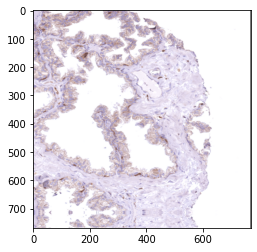

MASK
torch.Size([768, 768])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


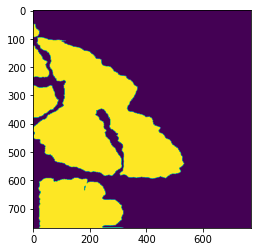

In [25]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [26]:
BATCH_SIZE = 5

In [27]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

IMAGE
torch.Size([3, 768, 768])
image values:  0.027450982481241226 1.0


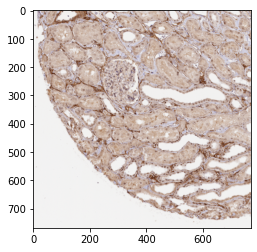

MASK
torch.Size([768, 768])
mask values:  tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


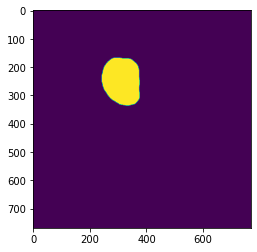

In [28]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# model

In [29]:
!nvidia-smi

Sat Aug 20 13:23:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   49C    P0    56W / 300W |   8602MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   50C    P0    55W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [30]:
device = 'cuda:2'
DEVICE = device

In [31]:
pretrain_dir = './../mit-b2-segformer-first-try/'

In [32]:
model = Net().to(device)

In [33]:
chkpts = []
for fname in sorted(glob('./checkpoint_fold_3/mit-b2_ep_*_dice_*.pt')):
#     print(fname)
    bname = os.path.basename(fname)
    spt = bname.split('_')
    epoch = int(spt[2])
    dice = float(spt[4].rsplit('.', maxsplit=1)[0])
    print(epoch, dice)
    chkpts.append((fname, dice, epoch))

0 0.421225
3 0.75408
6 0.745868
9 0.761714
12 0.760784
15 0.772742
18 0.750758
21 0.776939
24 0.749422
27 0.738993
30 0.758037
33 0.769463
36 0.764191
39 0.744923
42 0.716308
45 0.757128
48 0.774469
51 0.760248
54 0.766483
57 0.764452
60 0.762145
63 0.753205
66 0.756277
69 0.767298
72 0.764378
75 0.749095
78 0.754425
81 0.76431
84 0.717739


In [37]:
chkpts = list(sorted(chkpts, key=lambda x: x[1]))

In [39]:
chkpts[-7:]

[('./checkpoint_fold_3/mit-b2_ep_057_dice_0.764452.pt', 0.764452, 57),
 ('./checkpoint_fold_3/mit-b2_ep_054_dice_0.766483.pt', 0.766483, 54),
 ('./checkpoint_fold_3/mit-b2_ep_069_dice_0.767298.pt', 0.767298, 69),
 ('./checkpoint_fold_3/mit-b2_ep_033_dice_0.769463.pt', 0.769463, 33),
 ('./checkpoint_fold_3/mit-b2_ep_015_dice_0.772742.pt', 0.772742, 15),
 ('./checkpoint_fold_3/mit-b2_ep_048_dice_0.774469.pt', 0.774469, 48),
 ('./checkpoint_fold_3/mit-b2_ep_021_dice_0.776939.pt', 0.776939, 21)]

In [40]:
model.load_state_dict(torch.load(chkpts[-8][0], map_location=device))

<All keys matched successfully>

In [41]:
swa_model = AveragedModel(model)

In [42]:
for el in chkpts[-7:]:
    model.load_state_dict(torch.load(el[0], map_location=device))
    swa_model.update_parameters(model)

In [39]:
# model.load_state_dict(torch.load('./checkpoint_fold_3_SAM/mit-b2_ep_501_dice_0.772775.pt', map_location=device))

<All keys matched successfully>

# training ADAM + SAM

# don't forget to call this after training

In [ ]:
# swa_model.load_state_dict(torch.load('..'))

In [43]:
swa_model = swa_model.to(device)

In [44]:
class HubmapDataset768(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        print(index)
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        
        image = self.transform(image=image)['image'].to(device)

        return {'image': image}

In [45]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [47]:
train_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] != CURRENT_FOLD], val_transform)
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False,
                          worker_init_fn=worker_init_fn,
                          num_workers=0
                         )

In [48]:
torch.optim.swa_utils.update_bn(loader_train, swa_model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064


3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704


5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344


6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943


In [49]:
torch.save(swa_model.state_dict(), os.path.join(
                    './checkpoint_fold_{}'.format(CURRENT_FOLD), 
                    'mit-b2_swa_ONLY_TOP_7_BEST_fixed_bn.pt'
                )) 

In [ ]:
# no amp version

In [ ]:
for epoch in range(0, N_EPOCHS):
    criterion_image, criterion_aux = criterion_schedule(epoch)
    
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
        
        batch['image'] = batch['image'].to(device)
        batch['mask' ] = batch['mask' ].to(device, dtype=torch.long)
#         batch['organ'] = batch['organ'].cuda()
        
        unfreeze_running_stats(model)

        output = model(batch)
        loss0      = criterion_image(output['out_logits'],   batch['mask'])
        loss_aux1  = criterion_aux  (output['aux1_logits'],  batch['mask']).mean()
        loss_aux2  = criterion_aux  (output['aux2_logits'],  batch['mask']).mean()
        loss = loss0 + 0.05 * loss_aux1 + 0.2 * loss_aux2
        
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        freeze_running_stats(model)  # <- this is the important line

        output = model(batch)
        loss0      = criterion_image(output['out_logits'],   batch['mask'])
        loss_aux1  = criterion_aux  (output['aux1_logits'],  batch['mask']).mean()
        loss_aux2  = criterion_aux  (output['aux2_logits'],  batch['mask']).mean()
        loss_act = loss0 + 0.05 * loss_aux1 + 0.2 * loss_aux2
            
        loss_act.backward()
        
        optimizer.second_step(zero_grad=True)
                 
        batch_train_loss.append(loss_act.item())          
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 5) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch, iteration, len(loader_train), loss.item()))


        if iteration % (VIRTUAL_BATCH_SIZE * 40) == 0:
            clear_output()

            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
        
    if epoch > SWA_START:
        swa_model.update_parameters(model)
        swa_scheduler.step()
        
    # val -------------------------------
    if epoch % 3 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                PTH_CKPT, 
                'mit-b2_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 
            if epoch > SWA_START:
                torch.save(swa_model.state_dict(), os.path.join(
                    PTH_CKPT, 
                    'mit-b2_swa_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
                )) 
            logfile.flush()
    